In [1]:
# Dependencies
#for model-building
from sklearn import (model_selection, 
                     preprocessing, 
                     linear_model, 
                     naive_bayes, 
                     metrics, 
                     svm)
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import (TfidfVectorizer, 
                                             CountVectorizer)
from sklearn import decomposition, ensemble

import pandas as pd
import numpy as np

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import distinctipy, concurrent.futures, xgboost, textblob, string, re, os, time, spacy, multiprocessing

from functools import partial

#for text pre-processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

2024-01-19 02:22:17.748828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 02:22:17.748892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 02:22:17.781603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 02:22:17.854652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 02:22:18.799950: W tensorflow/compiler/tf2

True

## Motivation

In recent years, large language models (LLMs) have become increasingly sophisticated, capable of generating text that is difficult to distinguish from human-written text. The topic is not only interesting from an educational point of view, but has implications in business live as well, where AI can be used for writing ads, articles, reviews etc., and could enable plagiarism and replace humans, which can create an even increased unemployement rate and even end professions with long history like journalist, reporter, etc.

This notebook was made for the project of the course BMETE15MF75 at Budapest University of Technology and Economy.

In this notebook we will implement several different approaches to **text classification**. The goal is to successfully identify human written and AI-written (by LLMs) texts. The idea of the project came from the [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text) kaggle competition.

## Introduction

In the case of this notebook our focus will be on essays written by middle and high school students, but the idea is quite general, and the pipeline can be easily reconfigured for other types of text as well.

That being said, we will try to build a model to identify which essay was written by middle and high school students, and which was written using a large language model. With the spread of LLMs, many people fear they will replace or alter work that would usually be done by humans. Educators are especially concerned about their impact on students’ skill development, though many remain optimistic that LLMs will ultimately be a useful tool to help students improve their writing skills.

At the forefront of academic concerns about LLMs is their potential to enable plagiarism. LLMs are trained on a massive dataset of text and code, which means that they are able to generate text that is very similar to human-written text. For example, students could use LLMs to generate essays that are not their own, missing crucial learning keystones. Your work on this competition can help identify telltale LLM artifacts and advance the state of the art in LLM text detection. By using texts of moderate length on a variety of subjects and multiple, unknown generative models, we aim to replicate typical detection scenarios and incentivize learning features that generalize across models. (source [kaggle](https://www.kaggle.com/competitions/llm-detect-ai-generated-text))

## Resources

When dealing with natural language processing (NLP), there are a large number of sources that can be used for learning and getting familiar with the topic. We used the following ones in creating this notebook:

1. kaggle, [Explained LLM Model](https://www.kaggle.com/code/zulqarnainali/explained-llm-model)
2. Abubakar Abid, Matthew Carrigan, Lysandre Debut, Sylvain Gugger, Dawood Khan, Merve Noyan, Lucile Saulnier, Lewis Tunstall, Leandro von Werra, [NLP course, Hugging Face](https://huggingface.co/learn/nlp-course/chapter0/1?fw=tf)
3. Shivam Bansal, [A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)
4. Vijaya Rani, [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)
5. Saravana Kumar, [Machine Learning Model for Distinguishing Human vs. ChatGPT Text](https://github.com/saro0307/AI-detector)

# Loading the data

In [2]:
# data = open('corpus').read()
# labels, texts = [], []
# for i, line in enumerate(data.split("\n")):
#     content = line.split()
#     labels.append(content[0])
#     texts.append(" ".join(content[1:]))
# # create a dataframe using texts and lables
# df_train = pd.DataFrame()
# df_train['text'] = texts
# # label encode the target variable 
# encoder = preprocessing.LabelEncoder()
# labels = encoder.fit_transform(labels)
# df_train['label'] = labels

In [3]:
# df_train = pd.read_csv(r'daigt_v2_train_preproc_NLP_v1.csv', index_col=0)
df_train = pd.read_csv(r'daigt-v2-train-dataset-augmented')
df_train = df_train.drop_duplicates(subset=['text'])
df_train.reset_index(drop=True, inplace=True)

In [4]:
df_train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True
4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True


In [5]:
df_train.text.iloc[1]

" Dear Senator [Name],\n\nI am writing to express my thoughts on the Electoral College and whether it works effectively in determining the outcome of presidential elections. As an 8th-grade student, I believe the current system is a fair and democratic way of choosing our president, but there are concerns that some may have regarding its use.\n\nFirstly, let me start by acknowledging that the idea of the Electoral College is rooted in compromise during the drafting of the US Constitution. The delegates at the constitutional convention debated whether to choose the president through the popular vote or by election in Congress. Compromise was ultimately reached, and the Electoral College was established to balance the interests of urban and rural areas, big states and small states.\n\nMoreover, the Electoral College provides for a larger role for small and rural states, which represent approximately 20% of the US population. A popular vote system would disproportionately favor states wit

In [6]:
# df_daig_v2 = pd.read_csv(r'train_v2_drcat_02.csv')
# df_daig_v2

label
0    27371
1    17897
Name: count, dtype: int64


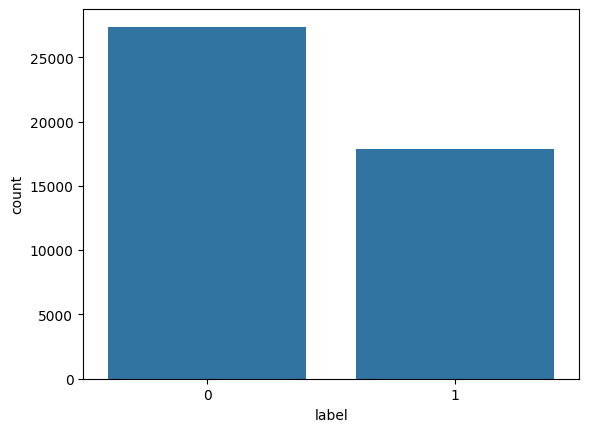

In [7]:
x = df_train.label.value_counts()
print(x)
sns.barplot(x)
plt.show()

In [8]:
df_train[df_train.label==1].source.value_counts()

source
mistral7binstruct_v2                  2421
chat_gpt_moth                         2421
mistral7binstruct_v1                  2421
llama2_chat                           2421
kingki19_palm                         1384
llama_70b_v1                          1172
falcon_180b_v1                        1055
darragh_claude_v7                     1000
darragh_claude_v6                     1000
mistralai/Mistral-7B-Instruct-v0.1     800
radek_500                              500
NousResearch/Llama-2-7b-chat-hf        400
cohere-command                         350
palm-text-bison1                       349
radekgpt4                              200
train_essays                             3
Name: count, dtype: int64

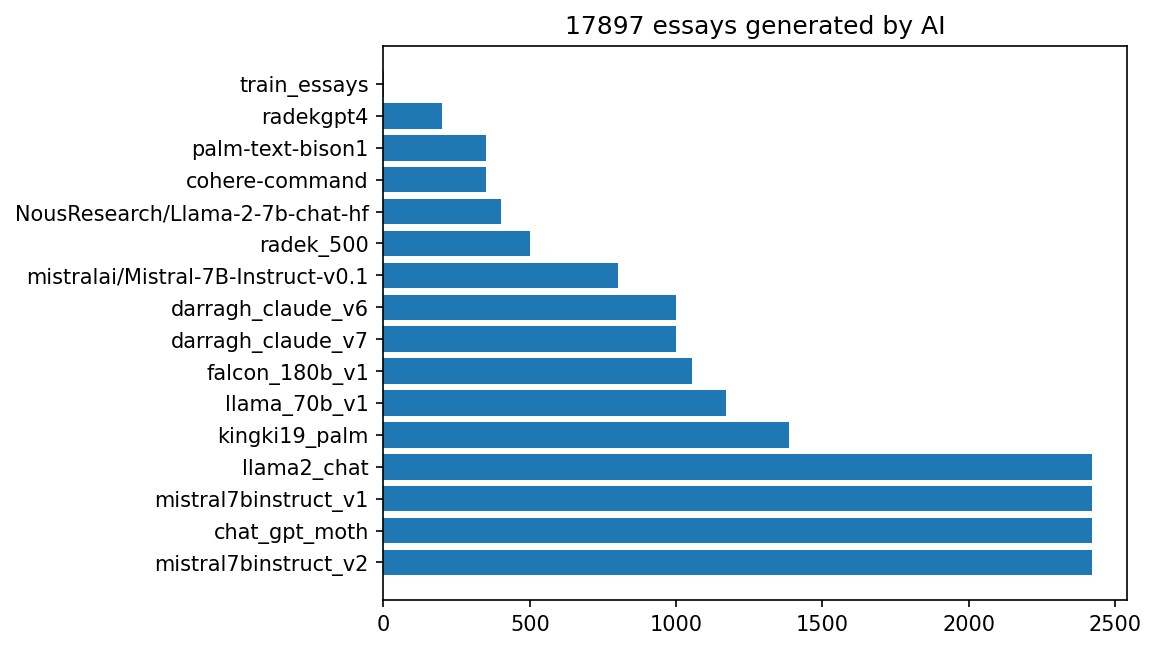

In [9]:
x = df_train[df_train.label==1].source.value_counts()

fig = plt.figure(dpi = 150)
plt.barh(x.index, x.values)
plt.title("{} essays generated by AI".format(x.values.sum()))
# plt.xticks(rotation=90) 
plt.show()

In [10]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print("Average word count for label 1: ", df_train[df_train['label']==1]['word_count'].mean()) 
print("Average word count for label 0: ", df_train[df_train['label']==0]['word_count'].mean()) 

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print("Average character count for label 1: ", df_train[df_train['label']==1]['char_count'].mean()) 
print("Average character count for label 0: ", df_train[df_train['label']==0]['char_count'].mean()) 

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print("Average unique word count for label 1: ", df_train[df_train['label']==1]['unique_word_count'].mean()) 
print("Average unique word count for label 0: ", df_train[df_train['label']==0]['unique_word_count'].mean()) 

Average word count for label 1:  338.8428786947533
Average word count for label 0:  418.2831463958204
Average character count for label 1:  2070.541040397832
Average character count for label 0:  2348.503890979504
Average unique word count for label 1:  172.4656087612449
Average unique word count for label 0:  199.85864601220268


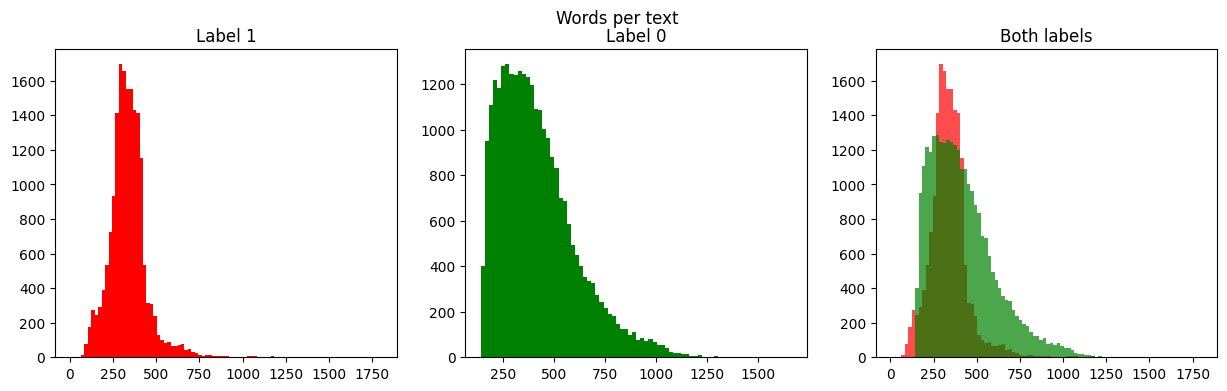

In [11]:
#Plotting word-count per essay
bin_size = 20
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,4))
train_words=df_train[df_train['label']==1]['word_count']
ax1.hist(train_words,color='red', bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax1.set_title('Label 1')
train_words=df_train[df_train['label']==0]['word_count']
ax2.hist(train_words,color='green', bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax2.set_title('Label 0')

train_words=df_train[df_train['label']==1]['word_count']
ax3.hist(train_words,color='red', alpha = .7,
         bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
train_words=df_train[df_train['label']==0]['word_count']
ax3.hist(train_words,color='green', alpha = .7,
         bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax3.set_title('Both labels')

fig.suptitle('Words per text')
plt.show()

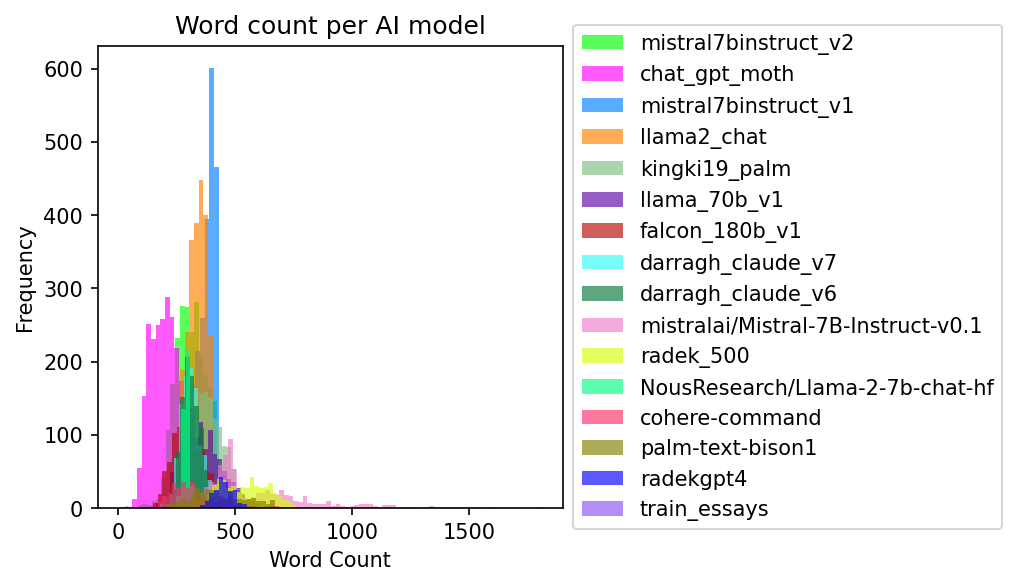

In [12]:
x = df_train[df_train.label==1].source.value_counts()
cmap = plt.get_cmap('tab20')
num_sources = len(x.index)
bin_size = 20
colors = distinctipy.get_colors(num_sources)
fig,ax =plt.subplots(figsize=(5,4), dpi = 150)
for i, source in enumerate(x.index):
    color = cmap(i / num_sources)
    train_words=df_train[(df_train['label']==1) & (df_train.source == source)]['word_count']
    ax.hist(train_words, bins=range(min(train_words), max(train_words) + bin_size, bin_size),
             histtype='stepfilled', label = source, alpha = .65, color=colors[i])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Word count per AI model')

plt.show()

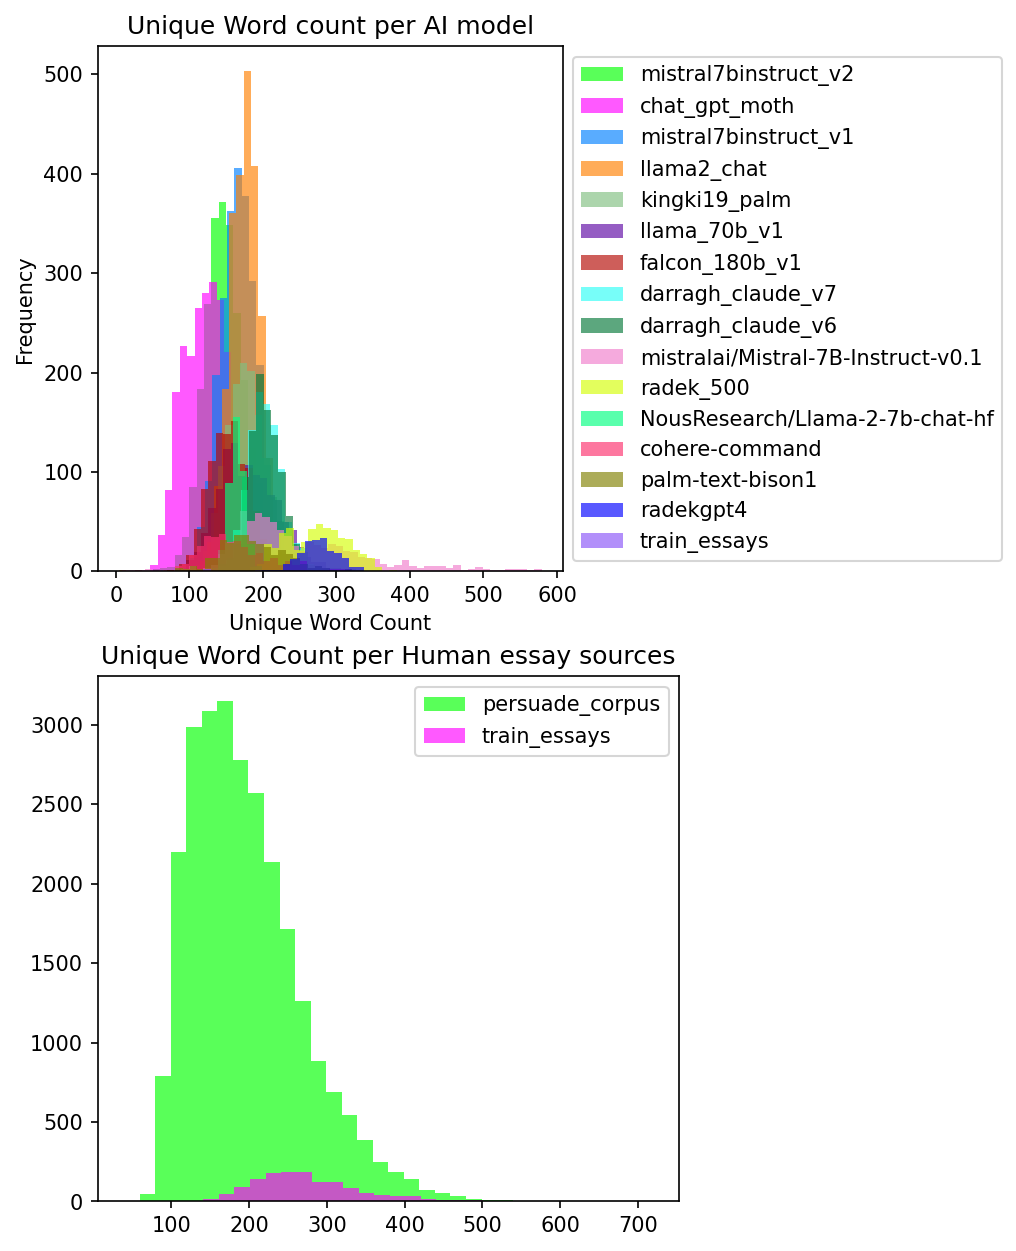

In [13]:
bin_size = 10
fig,(ax1, ax2) =plt.subplots(2,1,figsize=(5,10), dpi = 150)
for i, source in enumerate(x.index):
    color = cmap(i / num_sources)
    train_words=df_train[(df_train['label']==1) & (df_train.source == source)]['unique_word_count']
    ax1.hist(train_words, bins=range(min(train_words), max(train_words) + bin_size, bin_size),
             histtype='stepfilled', label = source, alpha = .65, color=colors[i])

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.set_xlabel('Unique Word Count')
ax1.set_ylabel('Frequency')
# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title('Unique Word count per AI model')

bin_size = 20
for i, source in enumerate(df_train[df_train.label==0].source.value_counts().index):
    color = cmap(i / num_sources)
    train_words=df_train[(df_train['label']==0) & (df_train.source == source)]['unique_word_count']
    ax2.hist(train_words, bins=range(min(train_words), max(train_words) + bin_size, bin_size),
             histtype='stepfilled', label = source, alpha = .65, color=colors[i])

# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax2.set_xlabel('Unique Word Count')
# ax2.set_ylabel('Frequency')
# Put a legend to the right of the current axis
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend()
ax2.set_title('Unique Word Count per Human essay sources')

plt.show()

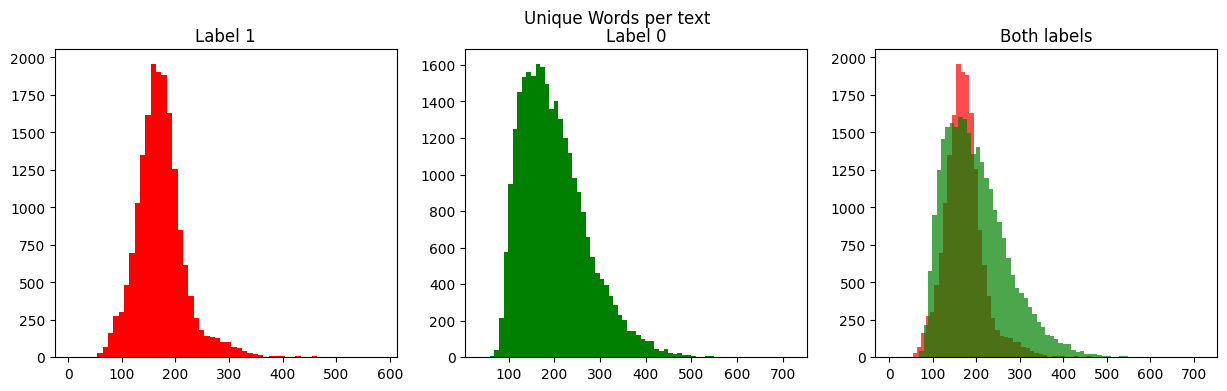

In [14]:
#Plotting word-count per essay
bin_size = 10
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,4))
train_words=df_train[df_train['label']==1]['unique_word_count']
ax1.hist(train_words,color='red', bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax1.set_title('Label 1')
train_words=df_train[df_train['label']==0]['unique_word_count']
ax2.hist(train_words,color='green', bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax2.set_title('Label 0')

train_words=df_train[df_train['label']==1]['unique_word_count']
ax3.hist(train_words,color='red', alpha = .7,
         bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
train_words=df_train[df_train['label']==0]['unique_word_count']
ax3.hist(train_words,color='green', alpha = .7,
         bins=range(min(train_words), max(train_words) + bin_size, bin_size),)
ax3.set_title('Both labels')
fig.suptitle('Unique Words per text')
plt.show()

In [15]:
df_train.head()

,text,label,prompt_name,source,RDizzl3_seven,word_count,char_count,unique_word_count
0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3667,249
1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,629,4086,302
2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3823,260
3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,416,2493,194
4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True,1298,7066,486


# Pre-processing

Here you can find a text pre-processing pipeline. We will remove any unnecessary characters and (re)format the text on demand. This can be important if we want to make the texts completely identic from a structural point of view. Stemming, lemmatization and stopword removal is also possible. We will be able to compare results with and without pre-processing.

In [16]:
"""
Strip the texts from upper and lower case, special characters, etc.
"""

def preprocess(text):
    text = text.lower()  # lowercase text
    text = text.strip()  # get rid of leading/trailing whitespace
    text = re.compile('<.*?>').sub('', text)  # Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  # Replace punctuation with space. Careful since punctuation can sometimes be useful
    text = re.sub('\s+', ' ', text)  # Remove extra space and tabs
    text = re.sub(r'\[[^\]]*\]', ' ', text)  # Remove content within square brackets and the brackets themselves
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d', ' ', text)  # matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+', ' ', text)  # \s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

    return text
def preprocess_simple(text):
    # text = text.lower()  # lowercase text
    text = text.strip()  # get rid of leading/trailing whitespace
    text = re.sub(r'\[[^\]]*\]', ' ', text)  # Remove content within square brackets and the brackets themselves
    text = re.compile('<.*?>').sub('', text)  # Remove HTML tags/markups
    text = re.sub('\s+', ' ', text)  # Remove extra space and tabs
    text = re.sub(r'\s+', ' ', text)  # \s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace

    return text

#3. LEXICON-BASED TEXT PROCESSING EXAMPLES
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
def finalpreprocess_simple(string):
    return lemmatizer(stopword(preprocess_simple(string)))

In [17]:
text = df_train.text.iloc[0]
len(text.split('\n')[0].split())

3

In [18]:
text = df_train.text.iloc[0]
print(text)
text=preprocess_simple(text)
print(text)  #text is a string

text=stopword(text)
print(text)

text=stemming(text)
print(text)

text = lemmatizer(text)
print(text)


 Dear Senator [Name],

I hope this message finds you well. In recent years, the topic of the electoral college has been hotly debated, and there has been a growing call to abolish it in favor of a popular vote system for the presidency. I would like to take this opportunity to express my point of view on the matter and argue in favor of keeping the electoral college.

Firstly, it is important to understand the role of the electoral college. The Electoral College is a system that was established by the founding fathers of the United States in order to give each state's population a proportionate say in the election of the president. Under this system, each state is allocated a certain number of electoral votes based on its population. The candidate who wins the popular vote in a given state receives all of that state's electoral votes.

One of the reasons that the electoral college was put in place was to prevent a candidate from winning the presidency simply by winning in densely popul

Apply pre-processing and save to a different data frame

In [19]:
# Function to process a single text entry
def process_text(text):
    return finalpreprocess(text)
# df_train_preproc = df_train.copy()
# tqdm.pandas(desc=f"Cleaning texts")
# df_train['clean_text'] = df_train['text'].progress_apply(lambda x: finalpreprocess(x))
# df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])

# Apply final preprocessing using ThreadPoolExecutor

# Determine the number of CPU cores and use max_workers accordingly
# I.e. leave some free CPU for ur poor system to live :)
max_workers = max(1, os.cpu_count() - 1)

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    df_train['clean_text'] = list(tqdm(executor.map(process_text, df_train['text']), total=len(df_train)))

df_train.head()

100%|██████████| 45268/45268 [02:56<00:00, 256.65it/s]


,text,label,prompt_name,source,RDizzl3_seven,word_count,char_count,unique_word_count,clean_text
0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3667,249,dear senator name hope message find well recen...
1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,629,4086,302,dear senator name write express thought electo...
2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3823,260,dear senator write express viewpoint electoral...
3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,416,2493,194,electoral college group elector ultimately sel...
4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True,1298,7066,486,cowboy boot clank wooden floorboard dust scurr...


In [20]:
# function to check and get the part of speech tag count of a words in a given sentence

df_train['word_density'] = df_train['char_count'] / (df_train['word_count']+1)
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df_train['title_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df_train['upper_case_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [21]:
# # This cell can run for a very long time! Use it on your own responsibility:)


# def check_pos_tag(x, flag):
#     cnt = 0
#     try:
#         wiki = textblob.TextBlob(x)
#         return sum(1 for tup in wiki.tags if tup[1] in pos_family[flag])
#         # for tup in wiki.tags:
#         #     ppo = list(tup)[1]
#         #     if ppo in pos_family[flag]:
#         #         cnt += 1
#     except:
#         return 0
#     # return cnt

# run2 = 1
# if run2:    
#     pos_family = {
#         'noun' : ['NN','NNS','NNP','NNPS'],
#         'pron' : ['PRP','PRP$','WP','WP$'],
#         'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
#         'adj' :  ['JJ','JJR','JJS'],
#         'adv' : ['RB','RBR','RBS','WRB']
#     }
#     for tag in pos_family:
#         tqdm.pandas(desc=f"Processing {tag} counts")
#         df_train[f'{tag.lower()}_count'] = df_train['text'].progress_apply(lambda x: check_pos_tag(x, tag))

In [22]:
# import spacy
# import concurrent.futures
# from tqdm import tqdm
# import os

# # Load the spaCy language model
# nlp = spacy.load("en_core_web_sm")

# pos_family = {
#     'noun' : ['NOUN', 'PROPN'],
#     'pron' : ['PRON'],
#     'verb' : ['VERB'],
#     'adj' : ['ADJ'],
#     'adv' : ['ADV']
# }

# def check_pos_tag(args):
#     x, flag = args
#     try:
#         doc = nlp(x)
#         return sum(1 for token in doc if token.pos_ in pos_family[flag])
#     except:
#         return 0

# # Determine the number of CPU cores and use max_workers accordingly
# max_workers = max(1, os.cpu_count() - 1)

# with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
#     args_list = ((x, tag) for tag in pos_family for x in df_train['text'])
#     print("Starting counting on {} CPUs out of {} CPUs".format(max_workers, os.cpu_count()))
#     results = list(tqdm(executor.map(check_pos_tag, args_list), total=len(df_train) * len(pos_family)))

#     index = 0
#     for tag in pos_family:
#         df_train[f'{tag.lower()}_count'] = results[index: index + len(df_train)]
#         index += len(df_train)

In [23]:
# import multiprocessing
# from functools import partial
# from tqdm import tqdm

# def check_pos_tag(x, flag, pos_family):
#     cnt = 0
#     try:
#         wiki = textblob.TextBlob(x)
#         return sum(1 for tup in wiki.tags if tup[1] in pos_family[flag])
#     except:
#         return 0

# def process_text(x, pos_family):
#     return {tag.lower() + '_count': check_pos_tag(x, tag, pos_family) for tag in pos_family}

# if __name__ == '__main__':
#     pos_family = {
#         'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
#         'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
#         'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
#         'adj': ['JJ', 'JJR', 'JJS'],
#         'adv': ['RB', 'RBR', 'RBS', 'WRB']
#     }
    
#     num_processes = multiprocessing.cpu_count() - 1  # Number of available CPU cores
#     pool = multiprocessing.Pool(num_processes)
#     partial_process_text = partial(process_text, pos_family=pos_family)
    
#     results = []
#     with tqdm(total=len(df_train['text']), desc="Processing") as pbar:
#         for result in pool.imap_unordered(partial_process_text, df_train['text']):
#             results.append(result)
#             pbar.update()
    
#     for result in results:
#         df_train = df_train.append(result, ignore_index=True)

In [25]:
# A better, parallelized version of the above cell
# tqdm... can have issues with concurrent.futures.ProcessPoolExecutor
# to remedy the problem apply the well known engineering solution:
# stop the cell (without killing/restarting the kernel, if it pops up, just cancel it) 
# and restart till tqdm progress bar shows up. If it doesn't show up after 40 sec - 1 min
# repeat the process

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}
def check_pos_tag(args):
    x, flag = args
    try:
        wiki = textblob.TextBlob(x)
        return sum(1 for tup in wiki.tags if tup[1] in pos_family[flag])
    except:
        return 0

max_workers = max(1, os.cpu_count() - 2)

# Convert the generator to a list
args_list = [(x, tag) for tag in pos_family for x in df_train['text']]

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    print("Starting counting on {} CPUs out of {} CPUs".format(max_workers, os.cpu_count()))
    time.sleep(.5)  
    # Use the list directly in tqdm
    results = list(tqdm(executor.map(check_pos_tag, args_list), total=len(df_train) * len(pos_family)))

index = 0
for tag in pos_family:
    df_train[f'{tag.lower()}_count'] = results[index: index + len(df_train['text'])]
    index += len(df_train['text'])

Starting counting on 14 CPUs out of 16 CPUs


100%|██████████| 226340/226340 [06:34<00:00, 573.33it/s]


In [26]:
df_train.iloc[:5]

,text,label,prompt_name,source,RDizzl3_seven,word_count,char_count,unique_word_count,clean_text,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,pron_count,verb_count,adj_count,adv_count
0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3667,249,dear senator name hope message find well recen...,5.991830,59,42,3,150,27,103,59,39
1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,629,4086,302,dear senator name write express thought electo...,6.485714,76,64,7,191,21,87,75,34
2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3823,260,dear senator write express viewpoint electoral...,6.246732,64,37,5,165,32,94,53,41
3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,416,2493,194,electoral college group elector ultimately sel...,5.978417,34,23,0,101,19,64,46,25
4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True,1298,7066,486,cowboy boot clank wooden floorboard dust scurr...,5.439569,174,66,0,304,172,229,70,67


In [27]:
df = pd.read_csv('daigt_v2_train_preproc_NLP_v1.csv', index_col=0)
df.head()

,text,label,prompt_name,source,RDizzl3_seven,word_count,char_count,unique_word_count,clean_text,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,379,2029,212,Phones Modern human today always phone . They ...,5.339474,46,37,0,80,88,20,41,46
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,366,2141,183,This essay explain driver able use electronic ...,5.833787,49,19,0,83,71,20,34,32
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,178,1044,112,"Driving use cellular device Today , society th...",5.832402,15,8,2,45,43,15,10,4
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,212,1243,117,Phones & Driving Drivers able use phone operat...,5.835681,26,19,1,52,42,16,12,13
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,332,1911,201,Cell Phone Operation While Driving The ability...,5.738739,29,19,0,82,59,27,19,16


In [28]:
df_train.clean_text.iloc[0], df.clean_text.iloc[0]

('dear senator name hope message find well recent year topic electoral college hotly debate grow call abolish favor popular vote system presidency would like take opportunity express point view matter argue favor keep electoral college firstly important understand role electoral college electoral college system establish found father united state order give state population proportionate say election president system state allocate certain number electoral vote base population candidate win popular vote give state receives state electoral vote one reason electoral college put place prevent candidate win presidency simply win densely populated urban area system ensure candidate nationwide one two large city would president particularly important early day unite state population evenly distribute across country however also important recognize electoral college limitation one big criticism system sometimes result candidate ignore certain state focus effort solely others candidate need wi

In [29]:
save_name = 'daigt_v2_train_preproc_NLP_aug_v1.csv'

df_train.to_csv(save_name)